# **Final Report - Transforming Clinical Trial Labeling**

#### Joshua Scantlebury 

### MGTA611 - Winter 2024

## Contents

# Table of Contents

1. [Introduction](#introduction)
2. [Installing Required Dependencies](#installing-required-dependencies)
3. [Dataset Collection and Formatting](#dataset-collection-and-formatting)
4. [Exploratory Data Analysis for Text and Labels](#exploratory-data-analysis-for-text-and-labels)
5. [Text Preprocessing](#text-preprocessing)
6. [Tokenization and Model Setup](#tokenization-and-model-setup)
7. [Model Training](#model-training)
8. [Evaluation of the Transformer Model](#evaluation-of-the-transformer-model)
9. [Simple Logistic Regression Model](#simple-logistic-regression-model)
10. [Data Preparation for Logistic Regression Model](#data-preparation-for-logistic-regression-model)
11. [Vectorization and Label Extraction](#vectorization-and-label-extraction)
12. [Evaluation of the Logistic Regression Model](#evaluation-of-the-logistic-regression-model)
13. [Conclusion](#conclusion)
14. [References](#references)
15. [Literature Review](#literature-review)


## Introduction 

Many companies struggle to pass clinical trials due to the costs associated with conducting all four phases and the low percentages of success in bringing their products to market. On average, the duration of a clinical trial is 2.7-3.8 years, with less than an 8% chance of receiving full approval from the FDA. The average cost of clinical trials in therapeutic areas over phases one, two, and three can amount to $4 million, $13 million, and $20 million respectively. The FDA monitors clinical trials to ensure that companies comply with the submission of trial progression as they advance through the phases, which can be accessed via ClinicalTrials.gov.

Given these statistics, it's integral for pharmaceutical companies to ensure that their pursuit of the next therapeutic has the highest likelihood of passing through all phases of clinical trials.

With over 400 thousand successful and failed clinical trials, it can be challenging for researchers to determine which prospective therapeutics can provide a viable candidate. It is common for data companies to sell structured information relating to various aspects of clinical trials if researchers do not have the resources to source it themselves. However, as mentioned later in the text, manual curation is often necessary to provide reputable and accurate information to researchers, a process that incurs costs and requires field experts.

For this project, my aim is to alleviate the burden of manual curation in determining why clinical trials come to an end. I plan to utilize the popular transformer model to assign structured labels to unstructured clinical trial text data.

To evaluate the performance of the transformer model, we will focus on three main metrics: precision, recall, and F1 score. Additionally, I intend to construct a basic logistic regression classifier to benchmark the model and assess the advantages of using the transformer model.

In an effort to maximize the utilization of curator efforts, the idea is that this model can be continuously adapted to integrate with new data, enhancing its ability to assign a class to each clinical trial.


## Installing Required Dependencies

In [3]:
pip install datasets pandas datasets scikit-learn matplotlib tensorflow -q

Note: you may need to restart the kernel to use updated packages.


In [4]:
! pip install -U accelerate -q
! pip install -U transformers -q

In [5]:
import pandas as pd
import numpy as np
import re
from collections import Counter

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression

from transformers import (
    AutoModelForSequenceClassification, 
    TrainingArguments, 
    Trainer, 
    AutoTokenizer, 
    DataCollatorWithPadding
)
from datasets import load_dataset, DatasetDict


/Users/joshuascantlebury/miniconda3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Dataset collection and Formatting

Here, we will access a dataset from Hugging Face's datasets API. Although the data hasn’t been properly split into testing, training, and validation on their end, we will manually divide the dataset into training, testing, and validation sets. This is necessary to structure the data in a way that is friendly for building the transformer model. Additionally, we will create a dataframe using pandas to make the data much easier to process during our exploratory data analysis (EDA).

In [6]:
# Load dataset and split into train, valid, and test sets
ds = load_dataset("opentargets/clinical_trial_reason_to_stop")
ds_train_devtest = ds['train'].train_test_split(test_size=0.2, seed=42)
ds_devtest = ds_train_devtest['test'].train_test_split(test_size=0.5, seed=42)

# Create dataset dictionary for splits
ds_splits = DatasetDict({'train': ds_train_devtest['train'],
                         'valid': ds_devtest['train'],
                         'test': ds_devtest['test']})

# Convert datasets to pandas dataframes
dataframes = {split: ds.to_pandas() for split, ds in ds_splits.items()}

# Combine dataframes
combined_df = pd.concat(dataframes.values(), ignore_index=True)

## Exploratory Data Analysis for Text and Labels

Although the dataset has been cleaned during the manual curation process, I want to visually observe trends within the data. Therefore, we will examine the distribution of classes, the average length of a sentence, and some of the most common words present within the document. These factors will be important in understanding the data and its implications on the transformer model.

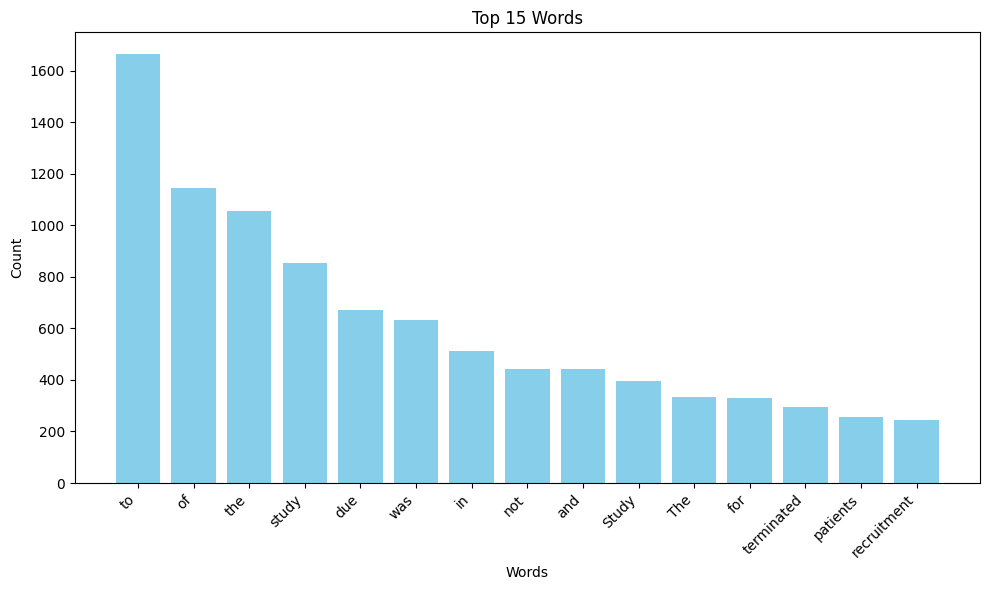

In [7]:
text_combined = ' '.join(combined_df["text"])  # Combine all text into a single string
words = text_combined.split()  # Split the text into words
word_counts = Counter(words)  # Count the occurrences of each word

word_counts_df = pd.DataFrame(word_counts.items(), columns=['Word', 'Count'])

word_counts_df = word_counts_df.sort_values(by='Count', ascending=False)

word_counts_df = word_counts_df.reset_index(drop=True)

# Plotting the top 15 words
top_15_words = word_counts_df.head(15)

plt.figure(figsize=(10, 6))
plt.bar(top_15_words['Word'], top_15_words['Count'], color='skyblue')
plt.xlabel('Words')
plt.ylabel('Count')
plt.title('Top 15 Words')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [8]:
def count_characters(texts):  # Count characters in texts
    total_characters = 0  # Initialize total character count
    for text in texts:  # Iterate through texts
        total_characters += len(text)  # Add length of each text to total
    return total_characters  # Return total character count

clinical_trials_reason_why_stopped = combined_df["text"]  # Extract text data
total_characters = count_characters(clinical_trials_reason_why_stopped)  # Calculate total characters
average_amount_of_characters = total_characters / len(clinical_trials_reason_why_stopped)  # Calculate average characters per corpus
print(f"the average amount of characters per corpus is ~", round(average_amount_of_characters,0)) 

the average amount of characters per corpus is ~ 58.0


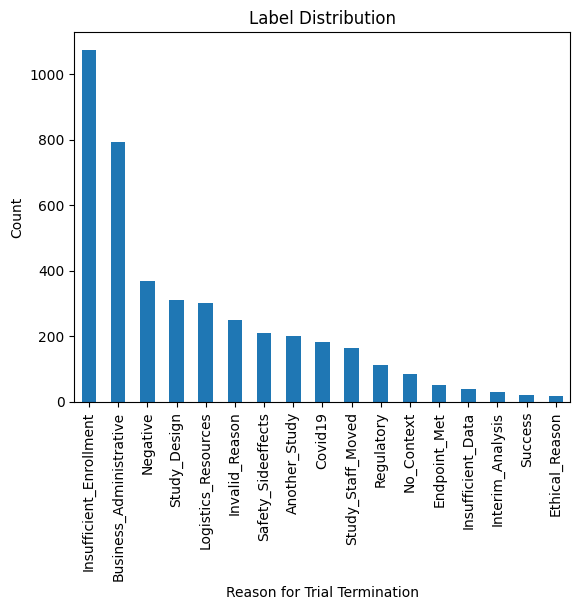

In [9]:
# Remove unnecessary columns
label_list = combined_df.drop(["label_descriptions","text"], axis=1)

# Count occurrences of True values
true_counts = label_list[label_list == True].count()

# Sort counts in descending order
true_counts_sorted = true_counts.sort_values(ascending=False)

# Plot bar chart
true_counts_sorted.plot(kind='bar')

# Add title and labels
plt.title('Label Distribution')
plt.xlabel('Reason for Trial Termination')
plt.ylabel('Count')
plt.show()

## Text Preprocessing 

As noted during the Exploratory Data Analysis (EDA), I've devised a function that eliminates any characters from the input text that aren't letters or whitespace. In this context, I inferred that numbers and special characters hold no significance in interpreting this text.

In [10]:
import re

# Function to clean text
def clean_text(text):
    cleaned_text = re.sub(r'[^A-Za-z\s]', '', text)
    return cleaned_text

# Preprocess datasets
def preprocess_datasets(ds_splits):
    for split in ds_splits.keys():
        ds_splits[split] = ds_splits[split].map(lambda example: {"text": clean_text(example["text"])})
    return ds_splits

# Apply preprocessing
ds_splits = preprocess_datasets(ds_splits)

# Tokenization and model setup


I'm extracting labels from the training dataset features, creating mappings between label indices and their corresponding labels, and defining a BERT model checkpoint for sequence classification. After initializing the tokenizer and the sequence classification model with BERT, I'm encoding the text data by tokenizing it, extracting labels, creating a labels matrix, and finally adding labels to the encoding. This process is then applied to dataset splits using batch processing.

In [11]:
# Extract labels from training dataset features
labels = [label for label in ds_splits['train'].features.keys() if label not in ['text', 'label_descriptions']]

# Create mappings between label indices and labels
id2label = {idx: label for idx, label in enumerate(labels)}
label2id = {label: idx for idx, label in enumerate(labels)}

In [12]:
# Define BERT model checkpoint
model_checkpoint = "bert-base-uncased"

# Initialize tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

# Initialize sequence classification model with BERT
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=len(labels))

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
def encode_text(examples):
    # Tokenize text
    text = examples["text"]
    encoding = tokenizer(text, padding="max_length", truncation=True, max_length=128)
    
    # Extract labels
    labels_batch = {k: examples[k] for k in examples.keys() if k in labels}
    
    # Create labels matrix
    labels_matrix = np.zeros((len(text), len(labels)))
    for idx, label in enumerate(labels):
        labels_matrix[:, idx] = labels_batch[label]
    
    # Add labels to encoding
    encoding["labels"] = labels_matrix.tolist()
    return encoding

# Apply text encoding to dataset splits
tokenized_ds_splits = ds_splits.map(encode_text, batched=True, remove_columns=ds_splits["train"].column_names)

Map: 100%|██████████| 375/375 [00:00<00:00, 22063.83 examples/s]


## Model Training

Here, I define the training arguments for my model, specifying parameters like the output directory, evaluation strategy, learning rate, batch sizes, epochs, and weight decay. Afterward, I initialize the Trainer object with the defined settings, including the model, datasets for training and evaluation, tokenizer, and data collator. This prepares the training environment with the specified configurations. Finally, I execute the training process.

In [57]:
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="steps",
    eval_steps=500, 
    learning_rate=5e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
)

In [58]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_ds_splits["train"],
    eval_dataset=tokenized_ds_splits["valid"],
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer)
)

In [59]:
# Train Model
trainer.train()

KeyboardInterrupt: 

## Evaluation of the transformer model

Here, I will evaluate the precision, recall, and F1 score for each class individually, as well as for the entire test set overall. This assessment will provide insights into the model's performance across different classes and its overall effectiveness in classification tasks.

In [63]:
def compute_and_display_metrics(pred_labels, true_labels):
    # Calculate class-specific metrics, handling division by zero explicitly
    precision_class, recall_class, f1_class, _ = precision_recall_fscore_support(
        true_labels, pred_labels, average=None, zero_division=0)
    # Calculate overall metrics using 'weighted' average, handling division by zero explicitly
    accuracy_overall = accuracy_score(true_labels, pred_labels)
    precision_overall, recall_overall, f1_overall, _ = precision_recall_fscore_support(
        true_labels, pred_labels, average='weighted', zero_division=0)
    
    # Class labels (replace with actual class names if available)
    class_labels = list(range(len(precision_class))) 
    
    metrics_df = pd.DataFrame({
        'Class Label': class_labels,
        'Precision': precision_class,
        'Recall': recall_class,
        'F1 Score': f1_class
    })
    
    overall_metrics_df = pd.DataFrame({
        'Class Label': ['Overall'],
        'Precision': [precision_overall],
        'Recall': [recall_overall],
        'F1 Score': [f1_overall]
    })
    metrics_df = pd.concat([metrics_df, overall_metrics_df], ignore_index=True)
    
    print(f"Overall Accuracy: {accuracy_overall:.4f}")
    print(f"Overall Precision: {precision_overall:.4f}")
    print(f"Overall Recall: {recall_overall:.4f}")
    print(f"Overall F1 Score: {f1_overall:.4f}")
    
    return metrics_df

metrics_df = compute_and_display_metrics(pred_labels, true_labels)
print(metrics_df)

Overall Accuracy: 0.0000
Overall Precision: 0.0000
Overall Recall: 0.0000
Overall F1 Score: 0.0000
   Class Label  Precision  Recall  F1 Score
0            0        0.0     0.0       0.0
1            1        0.0     0.0       0.0
2            2        0.0     0.0       0.0
3            3        0.0     0.0       0.0
4            4        0.0     0.0       0.0
5            5        0.0     0.0       0.0
6            6        0.0     0.0       0.0
7            7        0.0     0.0       0.0
8            8        0.0     0.0       0.0
9            9        0.0     0.0       0.0
10          10        0.0     0.0       0.0
11          11        0.0     0.0       0.0
12          12        0.0     0.0       0.0
13          13        0.0     0.0       0.0
14          14        0.0     0.0       0.0
15          15        0.0     0.0       0.0
16          16        0.0     0.0       0.0
17     Overall        0.0     0.0       0.0


## Simple Logistic Regression Model

Here, I will develop a basic logistic regression model to serve as a benchmark for comparison with my transformer model. The evaluation of this model will follow the same procedure as the evaluation of the transformer model, allowing for a direct comparison of their performance.

## Data Preparation for Logistic Regression Model 

In [ ]:
# Convert dataset splits to pandas DataFrames
df_train = ds_splits['train'].to_pandas()
df_valid = ds_splits['valid'].to_pandas()
df_test = ds_splits['test'].to_pandas()

# Combine validation and test datasets
df_combined = pd.concat([df_valid, df_test], ignore_index=True)

## Vectorization and Label Extraction

In [ ]:
# Initialize and fit TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=10000)  
X_train = tfidf_vectorizer.fit_transform(df_train['text'])
X_combined = tfidf_vectorizer.transform(df_combined['text'])

# Extract labels
y_train = df_train.drop(columns=['text', 'label_descriptions']).values
y_combined = df_combined.drop(columns=['text', 'label_descriptions']).values


## Evaluation of the Logistic Regression Model

In [90]:
# Initialize and train classifier
classifier = MultiOutputClassifier(LogisticRegression(max_iter=1000))
classifier.fit(X_train, y_train)

# Predict labels for combined dataset
combined_predictions = classifier.predict(X_combined)

In [91]:
def compute_and_display_metrics(pred_labels, true_labels):
   
    # Calculate class-specific metrics, handling division by zero explicitly
    precision_class, recall_class, f1_class, _ = precision_recall_fscore_support(
        true_labels, pred_labels, average=None, zero_division=0)
    
    # Calculate overall metrics using 'weighted' average, handling division by zero explicitly
    accuracy_overall = accuracy_score(true_labels, pred_labels)
    precision_overall, recall_overall, f1_overall, _ = precision_recall_fscore_support(
        true_labels, pred_labels, average='weighted', zero_division=0)
    
    # Class labels (replace with actual class names if available)
    class_labels = list(range(len(precision_class))) 
    
    # Create DataFrame for class-specific metrics
    metrics_df = pd.DataFrame({
        'Class Label': class_labels,
        'Precision': precision_class,
        'Recall': recall_class,
        'F1 Score': f1_class
    })
    
    # Create DataFrame for overall metrics
    overall_metrics_df = pd.DataFrame({
        'Class Label': ['Overall'],
        'Precision': [precision_overall],
        'Recall': [recall_overall],
        'F1 Score': [f1_overall]
    })
    
    # Concatenate class-specific and overall metrics DataFrames
    metrics_df = pd.concat([metrics_df, overall_metrics_df], ignore_index=True)
    
    # Print overall metrics
    print(f"Overall Accuracy: {accuracy_overall:.4f}")
    print(f"Overall Precision: {precision_overall:.4f}")
    print(f"Overall Recall: {recall_overall:.4f}")
    print(f"Overall F1 Score: {f1_overall:.4f}")
    
    return metrics_df

# Compute and display metrics
metrics_df = compute_and_display_metrics(combined_predictions, y_combined)
print(metrics_df)


Overall Accuracy: 0.4160
Overall Precision: 0.8661
Overall Recall: 0.4187
Overall F1 Score: 0.4935
   Class Label  Precision    Recall  F1 Score
0            0   1.000000  0.031250  0.060606
1            1   0.851064  0.588235  0.695652
2            2   1.000000  0.826087  0.904762
3            3   0.000000  0.000000  0.000000
4            4   0.000000  0.000000  0.000000
5            5   0.000000  0.000000  0.000000
6            6   0.884211  0.796209  0.837905
7            7   0.000000  0.000000  0.000000
8            8   0.875000  0.116667  0.205882
9            9   1.000000  0.054795  0.103896
10          10   0.742857  0.356164  0.481481
11          11   1.000000  0.250000  0.400000
12          12   1.000000  0.047619  0.090909
13          13   1.000000  0.151515  0.263158
14          14   1.000000  0.068966  0.129032
15          15   1.000000  0.333333  0.500000
16          16   0.000000  0.000000  0.000000
17     Overall   0.866079  0.418660  0.493454


## Conclusion

In this report, we employed a pre-trained BERT-like model to classify the reasons for clinical trial failures. The model demonstrated potential, highlighting the efficacy of transformer models in automating the classification of clinical trials.

However, the model's performance was modest, largely due to class imbalances affecting its evaluation, particularly evident in specific categories of clinical trial data. Limited samples hindered the model's ability to provide metrics for certain classes. A comparison with Logistic Regression showed promising improvements, with a 35% increase in F1 score and a 42% increase in Recall between the models. To enhance the prototype, augmenting it with more curated data is advisable, though obtaining clean annotated data remains challenging and hampers model training. Transformer models necessitate substantial data for optimal performance, and the current limitations indicate the model's inability to capture all data variations. This can be observed through the models performance amongst classes that were underpresented compared to classes that had ample data.

Nevertheless, despite these challenges, the transformer model performed relatively well compared to the basic logistic regression model, suggesting room for further improvement.

In conclusion, the transformer model exhibits promise with classes that have ample data samples. Integrating it into an architecture where manual curation can occur simultaneously during training holds potential for developing a deep learning model with expertise akin to human capabilities. Such integration, combined with human intelligence efforts could drive innovation in this field which can lead to reducing therapeutic development costs for companies.


## References

Knox, C., Wilson, M., Klinger, C. M., Franklin, M., Oler, E., Wilson, A., Pon, A., Cox, J., Chin, N. E. L., Strawbridge, S. A., Garcia-Patino, M., Kruger, R., Sivakumaran, A., Sanford, S., Doshi, R., Khetarpal, N., Fatokun, O., Doucet, D., Zubkowski, A., Rayat, D. Y., … Wishart, D. S. (2024). DrugBank 6.0: the DrugBank Knowledgebase for 2024. Nucleic acids research, 52(D1), D1265–D1275. https://doi.org/10.1093/nar/gkad976

Chen, Q., Allot, A., Leaman, R., Islamaj, R., Du, J., Fang, L., Wang, K., Xu, S., Zhang, Y., Bagherzadeh, P., Bergler, S., Bhatnagar, A., Bhavsar, N., Chang, Y. C., Lin, S. J., Tang, W., Zhang, H., Tavchioski, I., Pollak, S., Tian, S., … Lu, Z. (2022). Multi-label classification for biomedical literature: an overview of the BioCreative VII LitCovid Track for COVID-19 literature topic annotations. Database : the journal of biological databases and curation, 2022, baac069. https://doi.org/10.1093/database/baac069

OpenTargets. (n.d.). stopReasons. GitHub. Retrieved from https://github.com/opentargets/stopReasons

Rogge, N. (n.d.). Fine tuning BERT (and friends) for multi-label text classification. Retrieved from https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/BERT/Fine_tuning_BERT_(and_friends)_for_multi_label_text_classification.ipynb

OpenAI. (2024, 02 28). ChatGPT 3.5. Retrieved from https://chat.openai.com




## Literature Review

### DrugBank 6.0: the DrugBank Knowledgebase for 2024

With this paper serving as my main inspiration, I've had the privilege of gaining firsthand insight into the importance of labeling clinical trials and understanding why they fail. Given the abundance of unstructured information surrounding clinical trials, I've personally been involved as an annotator in this process. It's a tedious task that could greatly benefit from automation, provided there's a robust data source for training purposes. The underlying concept of this project was to progressively train a model alongside human annotators, enabling it to adapt as more expert-curated data becomes available.

Furthermore, clinical trial data offers numerous avenues for interpretation due to the multitude of reported factors. Seeking to streamline this process, I observed the successful application of transformer models in similar tasks and believe their deployment in this context could yield significant improvements in efficiency. By leveraging additional data sources such as *Drugbank 6.0*, there is potential to enhance databases, enabling researchers to identify prospective therapeutics more effectively and ultimately saving companies resources.

As the field of medicine continues to evolve, the wealth of data available online presents opportunities to structure and extract insights using NLP methods in conjunction with existing literature and research. This integration promises the development of innovation in healthcare.


### Multi-label classification for biomedical literature: an overview of the BioCreative VII LitCovid Track for COVID-19 literature topic annotations 

From this paper, I drew inspiration to implement automatic label identification for clinical trials based on the reasons for their termination. The paper highlights the challenges posed by the overwhelming influx of COVID-19-related articles, underscoring the difficulty in manually curating topics. Similar to my objective, the paper utilized transformer models to automate the process. While the paper employed bioBERT, pretrained to handle clinical trial data effectively, I opted for bert-bert uncased, believing that leveraging provided metadata would suffice in building a robust model without biobert. An important aspect of the paper was its use of label-based measures to assess model performance across various labels, particularly considering the severe class imbalance. This approach offers insights into how the model performs for dominant and underrepresented classes.